<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# Linear Regression with PyTorch
In this section we'll use PyTorch's machine learning model to progressively develop a best-fit line for a given set of data points. Like most linear regression algorithms, we're seeking to minimize the error between our model and the actual data, using a <em>loss function</em> like mean-squared-error.

<img src='../Images/linear-regression-residuals.png' width='400' style="display: inline-block"><br>

Image source: <a href='https://commons.wikimedia.org/wiki/File:Residuals_for_Linear_Regression_Fit.png'>https://commons.wikimedia.org/wiki/File:Residuals_for_Linear_Regression_Fit.png</a>

To start, we'll develop a collection of data points that appear random, but that fit a known linear equation $y = 2x+1$

## Perform standard imports

In [160]:
import torch
import torch.nn as nn  # we'll use this a lot going forward!

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Create a column matrix of X values
We can create tensors right away rather than convert from NumPy arrays.

In [161]:
X = torch.linspace(1,50,50).reshape(-1,1)

# Equivalent to
# X = torch.unsqueeze(torch.linspace(1,50,50), dim=1)

## Create a "random" array of error values
We want 50 random integer values that collectively cancel each other out.

In [162]:
torch.manual_seed(71) # to obtain reproducible results
e = torch.randint(-8,9,(50,1),dtype=torch.float)
print(e.sum())

tensor(0.)


## Create a column matrix of y values
Here we'll set our own parameters of $\mathrm {weight} = 2,\; \mathrm {bias} = 1$, plus the error amount.<br><strong><tt>y</tt></strong> will have the same shape as <strong><tt>X</tt></strong> and <strong><tt>e</tt></strong>

In [139]:
y = 2*X + 1 + e
print(y.shape)

torch.Size([50, 1])


## Plot the results
We have to convert tensors to NumPy arrays just for plotting.

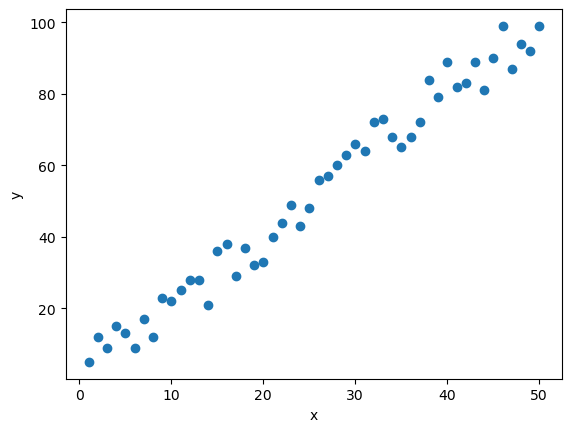

In [163]:
plt.scatter(X.numpy(), y.numpy())
plt.ylabel('y')
plt.xlabel('x');

Note that when we created tensor $X$, we did <em>not</em> pass <tt>requires_grad=True</tt>. This means that $y$ doesn't have a gradient function, and <tt>y.backward()</tt> won't work. Since PyTorch is not tracking operations, it doesn't know the relationship between $X$ and $y$.

## Simple linear model
As a quick demonstration we'll show how the built-in <tt>nn.Linear()</tt> model preselects weight and bias values at random.

In [164]:
torch.manual_seed(59)

model = nn.Linear(in_features=1, out_features=1)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[0.1060]], requires_grad=True)
Parameter containing:
tensor([0.9638], requires_grad=True)


Without seeing any data, the model sets a random weight of 0.1060 and a bias of 0.9638.

## Model classes
PyTorch lets us define models as object classes that can store multiple model layers. In upcoming sections we'll set up several neural network layers, and determine how each layer should perform its forward pass to the next layer. For now, though, we only need a single <tt>linear</tt> layer.

In [165]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

<div class="alert alert-info"><strong>NOTE:</strong> The "Linear" model layer used here doesn't really refer to linear regression. Instead, it describes the type of neural network layer employed. Linear layers are also called "fully connected" or "dense" layers. Going forward our models may contain linear layers, convolutional layers, and more.</div>

When <tt>Model</tt> is instantiated, we need to pass in the size (dimensions) of the incoming and outgoing features. For our purposes we'll use (1,1).<br>As above, we can see the initial hyperparameters.

In [166]:
torch.manual_seed(59)
model = Model(1, 1)
print(model)
print('Weight:', model.linear.weight.item())
print('Bias:  ', model.linear.bias.item())

Model(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Weight: 0.10597813129425049
Bias:   0.9637961387634277


As models become more complex, it may be better to iterate over all the model parameters:

In [167]:
for name, param in model.named_parameters():
    print(name, '\t', param.item())

linear.weight 	 0.10597813129425049
linear.bias 	 0.9637961387634277


<div class="alert alert-info"><strong>NOTE:</strong> In the above example we had our Model class accept arguments for the number of input and output features.<br>For simplicity we can hardcode them into the Model:
         
<tt><font color=black>
class Model(torch.nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.linear = Linear(1,1)<br><br>
model = Model()
</font></tt><br><br>

Alternatively we can use default arguments:

<tt><font color=black>
class Model(torch.nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, in_dim=1, out_dim=1):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.linear = Linear(in_dim,out_dim)<br><br>
model = Model()<br>
<em>\# or</em><br>
model = Model(i,o)</font></tt>
</div>

Now let's see the result when we pass a tensor into the model.

In [168]:
x = torch.tensor([2.0])
print(model.forward(x))   # equivalent to print(model(x))

tensor([1.1758], grad_fn=<AddBackward0>)


which is confirmed with $f(x) = (0.1060)(2.0)+(0.9638) = 1.1758$

## Plot the initial model
We can plot the untrained model against our dataset to get an idea of our starting point.

In [169]:
x1 = np.array([X.min(),X.max()])
print(x1)

[ 1. 50.]


In [170]:
w1,b1 = model.linear.weight.item(), model.linear.bias.item()
print(f'Initial weight: {w1:.8f}, Initial bias: {b1:.8f}')
print()

y1 = x1*w1 + b1
print(y1)

Initial weight: 0.10597813, Initial bias: 0.96379614

[1.0697743 6.2627025]


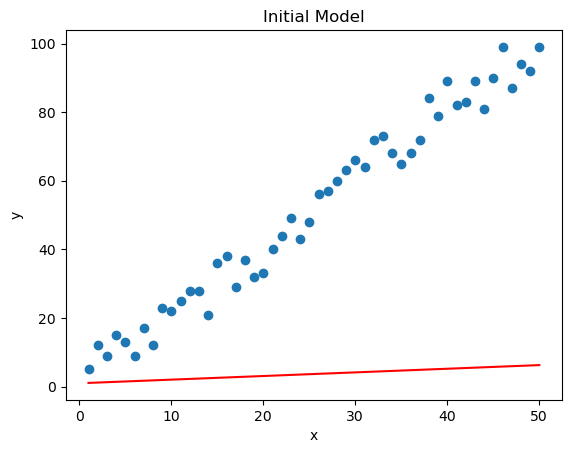

In [171]:
plt.scatter(X.numpy(), y.numpy())
plt.plot(x1,y1,'r')
plt.title('Initial Model')
plt.ylabel('y')
plt.xlabel('x');

## Set the loss function
We could write our own function to apply a Mean Squared Error (MSE) that follows<br>

$\begin{split}MSE &= \frac {1} {n} \sum_{i=1}^n {(y_i - \hat y_i)}^2 \\
&= \frac {1} {n} \sum_{i=1}^n {(y_i - (wx_i + b))}^2\end{split}$<br>

Fortunately PyTorch has it built in.<br>
<em>By convention, you'll see the variable name "criterion" used, but feel free to use something like "linear_loss_func" if that's clearer.</em>

In [172]:
criterion = nn.MSELoss()

## Set the optimization
Here we'll use <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent'>Stochastic Gradient Descent</a> (SGD) with an applied <a href='https://en.wikipedia.org/wiki/Learning_rate'>learning rate</a> (lr) of 0.001. Recall that the learning rate tells the optimizer how much to adjust each parameter on the next round of calculations. Too large a step and we run the risk of overshooting the minimum, causing the algorithm to diverge. Too small and it will take a long time to converge.

For more complicated (multivariate) data, you might also consider passing optional <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum'><tt>momentum</tt></a> and <a href='https://en.wikipedia.org/wiki/Tikhonov_regularization'><tt>weight_decay</tt></a> arguments. Momentum allows the algorithm to "roll over" small bumps to avoid local minima that can cause convergence too soon. Weight decay (also called an L2 penalty) applies to biases.

For more information, see <a href='https://pytorch.org/docs/stable/optim.html'><strong><tt>torch.optim</tt></strong></a>

In [173]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

# You'll sometimes see this as
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

## Train the model
An <em>epoch</em> is a single pass through the entire dataset. We want to pick a sufficiently large number of epochs to reach a plateau close to our known parameters of $\mathrm {weight} = 2,\; \mathrm {bias} = 1$

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take:</strong><br>

1. Set a reasonably large number of passes<br>
<tt><font color=black>epochs = 50</font></tt><br>
2. Create a list to store loss values. This will let us view our progress afterward.<br>
<tt><font color=black>losses = []</font></tt><br>
<tt><font color=black>for i in range(epochs):</font></tt><br>
3. Bump "i" so that the printed report starts at 1<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;i+=1</font></tt><br>
4. Create a prediction set by running "X" through the current model parameters<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;y_pred = model.forward(X)</font></tt><br>
5. Calculate the loss<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;loss = criterion(y_pred, y)</font></tt><br>
6. Add the loss value to our tracking list<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;losses.append(loss)</font></tt><br>
7. Print the current line of results<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;print(f'epoch: {i:2} loss: {loss.item():10.8f}')</font></tt><br>
8. Gradients accumulate with every backprop. To prevent compounding we need to reset the stored gradient for each new epoch.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;optimizer.zero_grad()</font></tt><br>
9. Now we can backprop<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;loss.backward()</font></tt><br>
10. Finally, we can update the hyperparameters of our model<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;optimizer.step()</font></tt>
</div>

In [181]:
epochs = 10000
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X)
    loss = criterion(y_pred, y)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}  weight: {model.linear.weight.item():10.8f}  \
bias: {model.linear.bias.item():10.8f}') 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 21.03310776  weight: 1.98277164  bias: 1.09101629
epoch:  2  loss: 21.03262138  weight: 1.98275089  bias: 1.09171295
epoch:  3  loss: 21.03214264  weight: 1.98273027  bias: 1.09240925
epoch:  4  loss: 21.03165436  weight: 1.98270953  bias: 1.09310520
epoch:  5  loss: 21.03117180  weight: 1.98268902  bias: 1.09380078
epoch:  6  loss: 21.03068352  weight: 1.98266792  bias: 1.09449601
epoch:  7  loss: 21.03020668  weight: 1.98264778  bias: 1.09519100
epoch:  8  loss: 21.02972221  weight: 1.98262680  bias: 1.09588563
epoch:  9  loss: 21.02923775  weight: 1.98260641  bias: 1.09657991
epoch: 10  loss: 21.02875710  weight: 1.98258555  bias: 1.09727383
epoch: 11  loss: 21.02827644  weight: 1.98256516  bias: 1.09796739
epoch: 12  loss: 21.02779388  weight: 1.98254430  bias: 1.09866059
epoch: 13  loss: 21.02731705  weight: 1.98252392  bias: 1.09935355
epoch: 14  loss: 21.02683067  weight: 1.98250341  bias: 1.10004616
epoch: 15  loss: 21.02635574  weight: 1.98248279  bias: 1.1007

epoch: 1475  loss: 20.65208054  weight: 1.96096754  bias: 1.82487845
epoch: 1476  loss: 20.65195847  weight: 1.96095753  bias: 1.82521939
epoch: 1477  loss: 20.65184784  weight: 1.96094728  bias: 1.82556009
epoch: 1478  loss: 20.65173149  weight: 1.96093714  bias: 1.82590067
epoch: 1479  loss: 20.65161705  weight: 1.96092725  bias: 1.82624114
epoch: 1480  loss: 20.65149689  weight: 1.96091688  bias: 1.82658136
epoch: 1481  loss: 20.65138245  weight: 1.96090686  bias: 1.82692146
epoch: 1482  loss: 20.65127182  weight: 1.96089685  bias: 1.82726133
epoch: 1483  loss: 20.65115738  weight: 1.96088648  bias: 1.82760108
epoch: 1484  loss: 20.65103531  weight: 1.96087682  bias: 1.82794070
epoch: 1485  loss: 20.65092278  weight: 1.96086633  bias: 1.82828009
epoch: 1486  loss: 20.65080643  weight: 1.96085656  bias: 1.82861936
epoch: 1487  loss: 20.65068817  weight: 1.96084619  bias: 1.82895839
epoch: 1488  loss: 20.65057945  weight: 1.96083653  bias: 1.82929730
epoch: 1489  loss: 20.65046310  we

epoch: 2899  loss: 20.56225586  weight: 1.95054853  bias: 2.17555714
epoch: 2900  loss: 20.56222725  weight: 1.95054317  bias: 2.17572808
epoch: 2901  loss: 20.56219673  weight: 1.95053840  bias: 2.17589903
epoch: 2902  loss: 20.56217003  weight: 1.95053315  bias: 2.17606974
epoch: 2903  loss: 20.56213951  weight: 1.95052814  bias: 2.17624044
epoch: 2904  loss: 20.56211090  weight: 1.95052314  bias: 2.17641091
epoch: 2905  loss: 20.56208420  weight: 1.95051777  bias: 2.17658138
epoch: 2906  loss: 20.56205750  weight: 1.95051312  bias: 2.17675185
epoch: 2907  loss: 20.56202888  weight: 1.95050776  bias: 2.17692208
epoch: 2908  loss: 20.56200027  weight: 1.95050287  bias: 2.17709231
epoch: 2909  loss: 20.56196594  weight: 1.95049763  bias: 2.17726254
epoch: 2910  loss: 20.56193924  weight: 1.95049286  bias: 2.17743254
epoch: 2911  loss: 20.56191444  weight: 1.95048761  bias: 2.17760253
epoch: 2912  loss: 20.56188202  weight: 1.95048261  bias: 2.17777252
epoch: 2913  loss: 20.56185150  we

epoch: 4410  loss: 20.53906822  weight: 1.94510770  bias: 2.35868025
epoch: 4411  loss: 20.53906059  weight: 1.94510508  bias: 2.35876250
epoch: 4412  loss: 20.53905487  weight: 1.94510269  bias: 2.35884452
epoch: 4413  loss: 20.53904533  weight: 1.94510043  bias: 2.35892653
epoch: 4414  loss: 20.53903770  weight: 1.94509780  bias: 2.35900855
epoch: 4415  loss: 20.53903389  weight: 1.94509542  bias: 2.35909057
epoch: 4416  loss: 20.53902817  weight: 1.94509292  bias: 2.35917258
epoch: 4417  loss: 20.53901863  weight: 1.94509065  bias: 2.35925460
epoch: 4418  loss: 20.53901100  weight: 1.94508815  bias: 2.35933638
epoch: 4419  loss: 20.53900719  weight: 1.94508564  bias: 2.35941815
epoch: 4420  loss: 20.53899956  weight: 1.94508326  bias: 2.35949993
epoch: 4421  loss: 20.53899193  weight: 1.94508088  bias: 2.35958171
epoch: 4422  loss: 20.53899002  weight: 1.94507837  bias: 2.35966349
epoch: 4423  loss: 20.53897667  weight: 1.94507587  bias: 2.35974526
epoch: 4424  loss: 20.53896904  we

epoch: 5944  loss: 20.53367233  weight: 1.94246566  bias: 2.44760346
epoch: 5945  loss: 20.53366661  weight: 1.94246435  bias: 2.44764256
epoch: 5946  loss: 20.53366852  weight: 1.94246340  bias: 2.44768167
epoch: 5947  loss: 20.53366852  weight: 1.94246185  bias: 2.44772077
epoch: 5948  loss: 20.53366280  weight: 1.94246101  bias: 2.44775987
epoch: 5949  loss: 20.53366661  weight: 1.94245958  bias: 2.44779873
epoch: 5950  loss: 20.53366661  weight: 1.94245875  bias: 2.44783759
epoch: 5951  loss: 20.53366661  weight: 1.94245732  bias: 2.44787645
epoch: 5952  loss: 20.53365898  weight: 1.94245636  bias: 2.44791532
epoch: 5953  loss: 20.53365898  weight: 1.94245517  bias: 2.44795418
epoch: 5954  loss: 20.53365707  weight: 1.94245410  bias: 2.44799304
epoch: 5955  loss: 20.53365517  weight: 1.94245291  bias: 2.44803190
epoch: 5956  loss: 20.53365517  weight: 1.94245172  bias: 2.44807076
epoch: 5957  loss: 20.53364944  weight: 1.94245040  bias: 2.44810963
epoch: 5958  loss: 20.53364944  we

epoch: 7454  loss: 20.53246117  weight: 1.94122314  bias: 2.48942232
epoch: 7455  loss: 20.53246498  weight: 1.94122243  bias: 2.48944116
epoch: 7456  loss: 20.53246307  weight: 1.94122207  bias: 2.48945999
epoch: 7457  loss: 20.53246498  weight: 1.94122124  bias: 2.48947883
epoch: 7458  loss: 20.53246307  weight: 1.94122088  bias: 2.48949766
epoch: 7459  loss: 20.53246117  weight: 1.94122028  bias: 2.48951650
epoch: 7460  loss: 20.53246117  weight: 1.94121969  bias: 2.48953533
epoch: 7461  loss: 20.53246307  weight: 1.94121921  bias: 2.48955417
epoch: 7462  loss: 20.53246117  weight: 1.94121850  bias: 2.48957276
epoch: 7463  loss: 20.53245544  weight: 1.94121814  bias: 2.48959136
epoch: 7464  loss: 20.53245544  weight: 1.94121742  bias: 2.48960996
epoch: 7465  loss: 20.53246117  weight: 1.94121706  bias: 2.48962855
epoch: 7466  loss: 20.53245544  weight: 1.94121623  bias: 2.48964715
epoch: 7467  loss: 20.53246117  weight: 1.94121599  bias: 2.48966575
epoch: 7468  loss: 20.53245926  we

epoch: 8947  loss: 20.53218269  weight: 1.94063008  bias: 2.50937819
epoch: 8948  loss: 20.53218460  weight: 1.94063008  bias: 2.50938725
epoch: 8949  loss: 20.53218460  weight: 1.94062960  bias: 2.50939631
epoch: 8950  loss: 20.53218842  weight: 1.94062924  bias: 2.50940537
epoch: 8951  loss: 20.53218842  weight: 1.94062912  bias: 2.50941443
epoch: 8952  loss: 20.53218269  weight: 1.94062877  bias: 2.50942349
epoch: 8953  loss: 20.53218460  weight: 1.94062865  bias: 2.50943255
epoch: 8954  loss: 20.53218269  weight: 1.94062829  bias: 2.50944161
epoch: 8955  loss: 20.53218269  weight: 1.94062793  bias: 2.50945067
epoch: 8956  loss: 20.53218269  weight: 1.94062781  bias: 2.50945973
epoch: 8957  loss: 20.53218842  weight: 1.94062734  bias: 2.50946879
epoch: 8958  loss: 20.53218842  weight: 1.94062734  bias: 2.50947785
epoch: 8959  loss: 20.53218269  weight: 1.94062686  bias: 2.50948691
epoch: 8960  loss: 20.53218079  weight: 1.94062686  bias: 2.50949597
epoch: 8961  loss: 20.53218842  we

## Plot the loss values
Let's see how loss changed over time

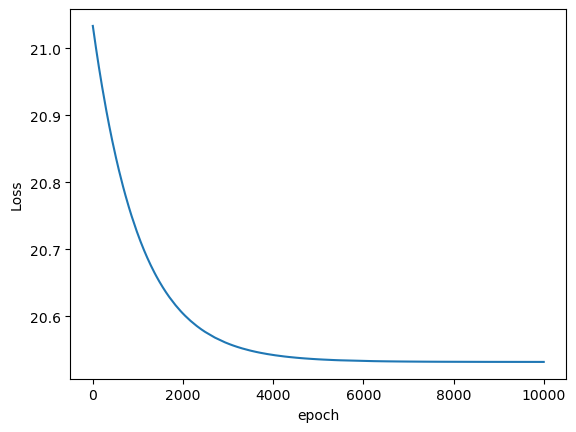

In [182]:
losses_numpy = [l.detach().numpy() for l in losses]
plt.plot(range(epochs), losses_numpy)
plt.ylabel('Loss')
plt.xlabel('epoch');

## Plot the result
Now we'll derive <tt>y1</tt> from the new model to plot the most recent best-fit line.

In [183]:
w1,b1 = model.linear.weight.item(), model.linear.bias.item()
print(f'Current weight: {w1:.8f}, Current bias: {b1:.8f}')
print()

y1 = x1*w1 + b1
print(x1)
print(y1)

Current weight: 1.94040692, Current bias: 2.51689315

[ 1. 50.]
[ 4.4573  99.53724]


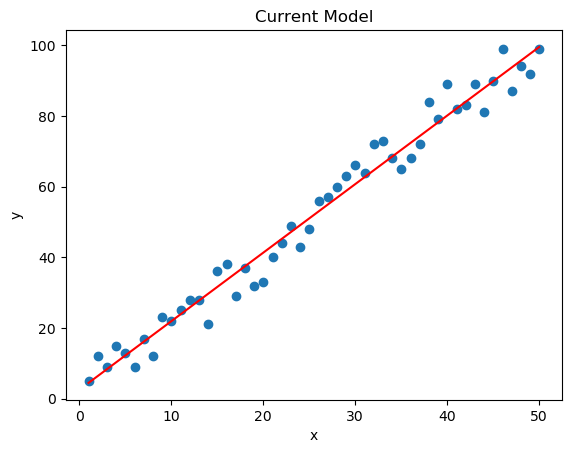

In [184]:
plt.scatter(X.numpy(), y.numpy())
plt.plot(x1,y1,'r')
plt.title('Current Model')
plt.ylabel('y')
plt.xlabel('x');

## Great job! Compare with sklearn or statsmodel

In [177]:
from sklearn import linear_model

In [178]:
X_numpy = X.numpy()
y_numpy = y.numpy()

In [179]:
lm = linear_model.LinearRegression()
lin_model = lm.fit(X_numpy,y_numpy)

In [180]:
# we see that we get the same results
print(lin_model.intercept_)
print(lin_model.coef_[0]) 

[2.528164]
[1.9400721]
